# loading and preprocessing

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import folium
import nltk

from collections import Counter
from nltk.corpus import stopwords
from folium.plugins import HeatMap

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample, class_weight
from imblearn.over_sampling import SMOTE

nltk.download('stopwords')
nltk.download('punkt')

# Load dataset
df = pd.read_csv('/Users/rawanr/Desktop/Rihal2025/Competition_Dataset.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rawanr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rawanr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(df.isnull().sum())
# Handling missing values
df.dropna(inplace=True)

Dates            0
Category         0
Descript         0
DayOfWeek        0
PdDistrict       0
Resolution       0
Address          0
Latitude (Y)     0
Longitude (X)    0
dtype: int64


In [3]:
print("Dataset Shape:", df.shape)

Dataset Shape: (680826, 9)


In [4]:
# Extract time-based features
df['Dates'] = pd.to_datetime(df['Dates'])
df['Hour'] = df['Dates'].dt.hour
df['Month'] = df['Dates'].dt.month
df['DayOfWeek'] = df['Dates'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# One-Hot Encode PdDistrict
district_ohe = pd.get_dummies(df['PdDistrict'], prefix='District')
df = pd.concat([df, district_ohe], axis=1)
df.drop(columns=['PdDistrict'], inplace=True)

In [5]:
print("Dataset Shape:", df.shape)

Dataset Shape: (680826, 21)


## Add new feature

In [6]:
# Define the reference point (center of dataset)
reference_lat = df['Latitude (Y)'].mean()
reference_lon = df['Longitude (X)'].mean()

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance from the reference point (center of the dataset)
df['distance_from_center'] = df.apply(lambda row: haversine(row['Latitude (Y)'], row['Longitude (X)'], reference_lat, reference_lon), axis=1)


The dataset had no missing values, so no handling of missing data was required. For the crime descriptions, **TF-IDF** vectorization was used to convert the text into numerical features, allowing the model to understand the importance of each word in predicting the outcome. The **Haversine formula** was applied to calculate the distance between the crimes and the central location, adding valuable geospatial information to the model. Finally, crime categories were encoded into numerical values using **LabelEncoder**, which is essential for machine learning algorithms to process categorical data effectively.

In [7]:
# Group by crime category and calculate mean distance
category_distance = df.groupby("Category")["distance_from_center"].agg(["mean", "median", "std"]).sort_values("mean")
print(category_distance)

                            mean    median        std
Category                                             
DRUG/NARCOTIC           1.890656  1.427141   1.436399
ROBBERY                 2.562319  1.959469  20.625918
BAD CHECKS              2.621115  2.174653   1.683421
WARRANTS                2.627573  1.680117  37.192115
EMBEZZLEMENT            2.660565  2.214228   1.739890
FRAUD                   2.688912  2.174653   1.898832
WEAPON LAWS             2.719305  2.174653   1.842026
KIDNAPPING              2.733233  2.174653   1.900160
NON-CRIMINAL            2.739373  2.173978  20.588655
LARCENY/THEFT           2.781301  2.118460  27.961409
FORGERY/COUNTERFEITING  2.785777  2.174653   1.968014
BRIBERY                 2.799711  2.298350   1.852630
TRESPASS                2.851771  1.977733  36.477542
BURGLARY                2.905818  2.264657  16.368516
VANDALISM               2.981208  2.379848   2.032853
OTHER OFFENSES          2.996752  2.061335  35.573594
SUSPICIOUS OCC          3.08

In [8]:
# Detecting outliers using IQR method 
Q1 = df['distance_from_center'].quantile(0.25)
Q3 = df['distance_from_center'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = df[(df['distance_from_center'] < lower_bound) | (df['distance_from_center'] > upper_bound)]

print(f"Number of outliers detected for 'distance_from_center': {outliers.shape[0]}")

# Option 1: Remove outliers
df_cleaned = df[(df['distance_from_center'] >= lower_bound) & (df['distance_from_center'] <= upper_bound)]

# Option 2: Cap outliers (replace outliers with upper or lower bound)
df['distance_from_center'] = np.where(df['distance_from_center'] < lower_bound, lower_bound, 
                                      np.where(df['distance_from_center'] > upper_bound, upper_bound, df['distance_from_center']))

print(f"Dataset Shape after handling outliers: {df_cleaned.shape}")

Number of outliers detected for 'distance_from_center': 32614
Dataset Shape after handling outliers: (648212, 22)


In [9]:
# Initialize the stop words
stop_words = set(stopwords.words('english'))

# Preprocessing function for text data 
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [10]:
# Apply preprocessing to the Descript column
df['Cleaned_Descript'] = df['Descript'].apply(preprocess_text)
df.drop(columns=['Descript'], inplace=True)
df.to_csv("Updated_Competition_Dataset.csv", index=False)

print(f"Columns in the updated DataFrame: {df.columns.tolist()}")

Columns in the updated DataFrame: ['Dates', 'Category', 'DayOfWeek', 'Resolution', 'Address', 'Latitude (Y)', 'Longitude (X)', 'Hour', 'Month', 'Weekend', 'District_BAYVIEW', 'District_CENTRAL', 'District_INGLESIDE', 'District_MISSION', 'District_NORTHERN', 'District_PARK', 'District_RICHMOND', 'District_SOUTHERN', 'District_TARAVAL', 'District_TENDERLOIN', 'distance_from_center', 'Cleaned_Descript']


In [11]:
# Apply TF-IDF Vectorization 
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust 'max_features' as needed
X_text = vectorizer.fit_transform(df['Cleaned_Descript'])

# Convert the TF-IDF sparse matrix to a dense array
X_text_array = X_text.toarray()

# Now, let's combine the TF-IDF features with other relevant features (e.g., distance_from_center)
X_final = np.hstack((X_text_array, df[['distance_from_center']].values))

# Keep relevant columns for model building
df_model = df[['Cleaned_Descript', 'distance_from_center', 'Category']]

In [12]:
# Encode the target variable 
label_encoder = LabelEncoder()
df_model['Category'] = label_encoder.fit_transform(df_model['Category'])

y_final = df_model['Category']

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

/var/folders/vs/yv99xdjd7g71b8gr5582fw5c0000gn/T/ipykernel_1465/2963366876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Category'] = label_encoder.fit_transform(df_model['Category'])


Training data shape: (544660, 711)
Test data shape: (136166, 711)


### Look for duplicate and overlapping columns.

In [13]:
overlapping_instances = df.groupby(df.columns.difference(["Category"]).tolist())["Category"].nunique()
overlapping_instances = overlapping_instances[overlapping_instances > 1]  # Keep only overlaps

print(f"Number of overlapping instances: {len(overlapping_instances)}")
print(overlapping_instances)


Number of overlapping instances: 2
Address                Cleaned_Descript    Dates                DayOfWeek  District_BAYVIEW  District_CENTRAL  District_INGLESIDE  District_MISSION  District_NORTHERN  District_PARK  District_RICHMOND  District_SOUTHERN  District_TARAVAL  District_TENDERLOIN  Hour  Latitude (Y)  Longitude (X)  Month  Resolution      Weekend  distance_from_center
2900 Block of 16TH ST  illegal substances  2012-08-20 10:48:00  0          0                 0                 0                   1                 0                  0              0                  0                  0                 0                    10    -122.419213   37.765134      8      ARREST, BOOKED  0        0.557221                2
TURK ST / JONES ST     illegal substances  2012-08-21 15:38:00  1          0                 0                 0                   0                 0                  0              0                  0                  0                 1                    15  

In [14]:
df["Category"] = df.groupby(df.columns.difference(["Category"]).tolist())["Category"].transform(lambda x: x.mode()[0])
df = df.drop_duplicates()

## visualization

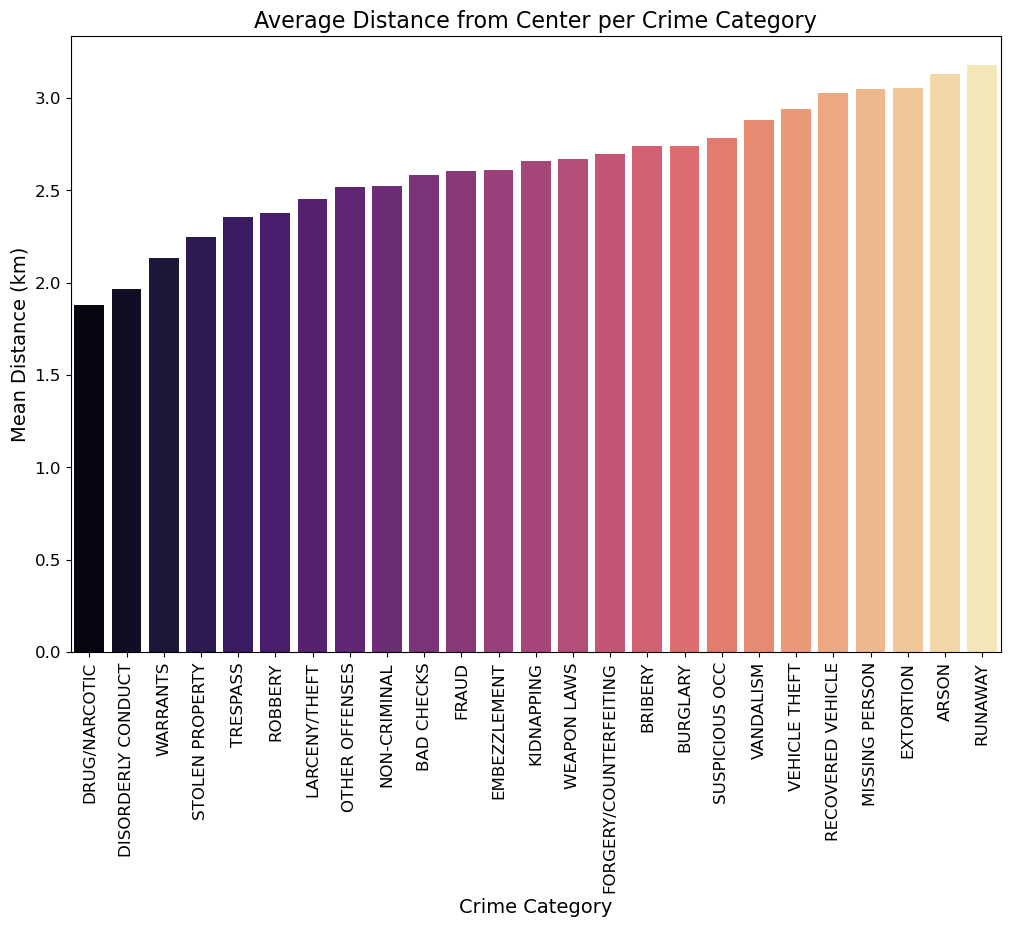

In [15]:
category_distance = df.groupby("Category")["distance_from_center"].agg(["mean", "median", "std"]).sort_values("mean")

plt.figure(figsize=(12, 8)) 
sns.barplot(data=category_distance, x=category_distance.index, y="mean", palette="magma")
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Average Distance from Center per Crime Category", fontsize=16)
plt.xlabel("Crime Category", fontsize=14)
plt.ylabel("Mean Distance (km)", fontsize=14)
plt.show()

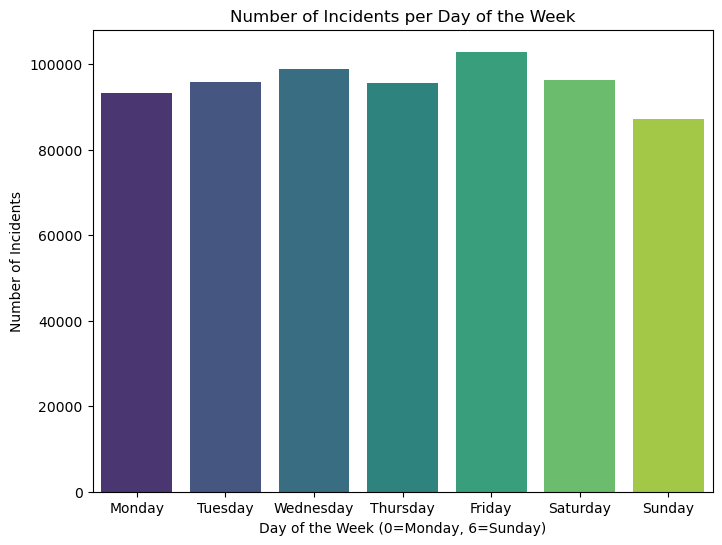

In [16]:
day_counts = df['DayOfWeek'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis')
plt.title('Number of Incidents per Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

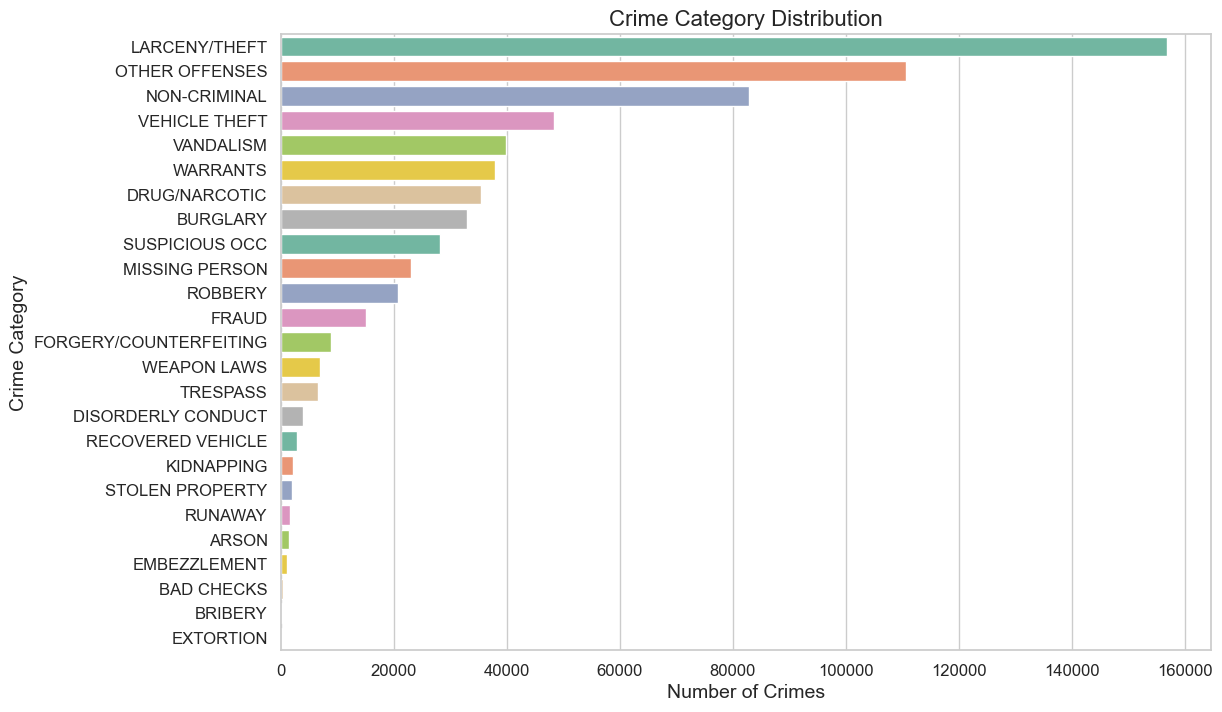

In [17]:
plt.figure(figsize=(12, 8))  
sns.set_theme(style="whitegrid")
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index, palette="Set2")
plt.xlabel("Number of Crimes", fontsize=14)
plt.ylabel("Crime Category", fontsize=14)
plt.title("Crime Category Distribution", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# modeling

## Random forest 

In [18]:
# Define RandomForest parameter grid with class weights
rf_param_dist = {
    'n_estimators': [100, 150],  
    'max_depth': [5, 10], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],  
    'class_weight': ['balanced']  # class weights to handle imbalance
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all cores for parallel processing

# Use RandomizedSearchCV for hyperparameter tuning with reduced iterations and folds
rf_search = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=3, cv=2, scoring='f1_macro', n_jobs=-1, random_state=42, verbose=1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [22]:
y_train_pred = best_rf.predict(X_train)
print(" Train Classification Report:\n", classification_report(y_train, y_train_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy: ", train_accuracy)

y_test_pred = best_rf.predict(X_test)
print(" Test Classification Report:\n", classification_report(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: ", test_accuracy)

 Train Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.98      0.70      1113
           1       1.00      1.00      1.00       292
           2       1.00      0.96      0.98       207
           3       1.00      1.00      1.00     26467
           4       0.74      1.00      0.85      3118
           5       1.00      0.96      0.98     35843
           6       0.26      1.00      0.41       826
           7       0.45      1.00      0.62       182
           8       1.00      0.92      0.96      7042
           9       0.97      0.78      0.87     12033
          10       1.00      0.98      0.99      1674
          11       1.00      0.98      0.99    125790
          12       1.00      1.00      1.00     18670
          13       1.00      0.85      0.92     66563
          14       0.87      0.99      0.93     88686
          15       0.25      0.97      0.39      2258
          16       0.98      1.00      0.99     16

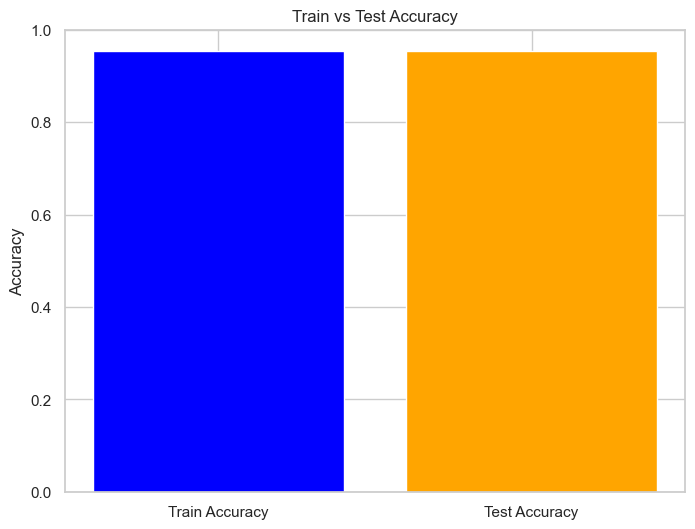

In [20]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
accuracy = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']

plt.bar(labels, accuracy, color=['blue', 'orange'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.show()

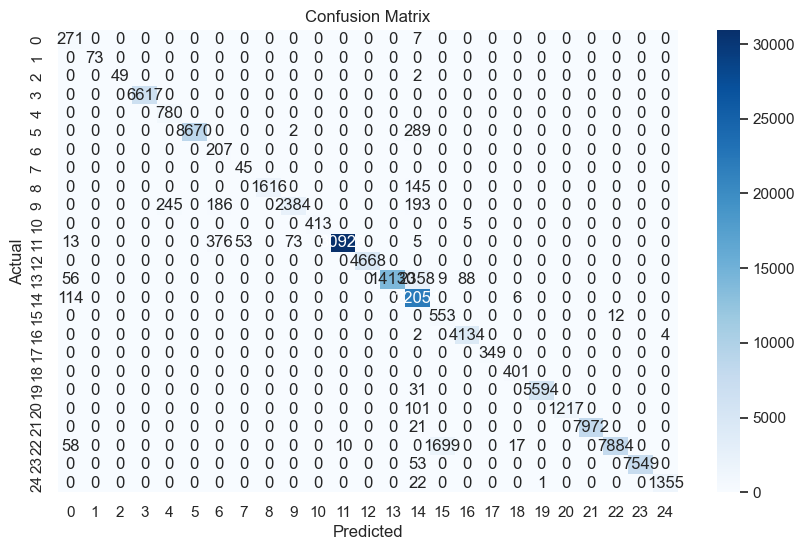

In [21]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

I chose Random Forest because it handles large datasets well, prevents overfitting by averaging multiple decision trees, and works with both numerical and categorical data. It also provides feature importance, helping identify key factors in predictions.

The model achieved a high accuracy of around 95% on both training and testing sets, indicating strong performance. However, it struggled with underrepresented classes like 6 and 15, showing lower precision and recall. While it performs well on majority classes, further techniques like oversampling could help improve its accuracy for minority classes. Overall, Random Forest proved effective but can be enhanced for class imbalance.

### hyperparameter tuning

In [25]:
# Define weak classes that need oversampling
weak_classes = [6, 7, 15]

# Apply SMOTE only to weak classes by increasing them to match 10% of the majority class
majority_class_count = max(np.bincount(y_train))
smote_strategy = {cls: int(0.1 * majority_class_count) for cls in weak_classes}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Compute new class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

rf_param_dist = {
    'n_estimators': [100],  
    'max_depth': [7],  
    'min_samples_split': [5],  
    'min_samples_leaf': [3],  
    'class_weight': [class_weight_dict]  
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=3, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42, verbose=1
)

rf_search.fit(X_train_resampled, y_train_resampled)
best_rf = rf_search.best_estimator_

/Users/rawanr/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/rawanr/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [27]:
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Train Accuracy:", train_accuracy)
print("\nTrain Classification Report (Resampled):")
print(classification_report(y_train_resampled, y_train_pred))

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9721582854311028

Train Classification Report (Resampled):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1113
           1       1.00      1.00      1.00       292
           2       1.00      0.96      0.98       207
           3       1.00      1.00      1.00     26467
           4       1.00      1.00      1.00      3118
           5       1.00      0.96      0.98     35843
           6       0.85      0.86      0.85     12579
           7       1.00      1.00      1.00     12579
           8       1.00      0.92      0.96      7042
           9       1.00      0.87      0.93     12033
          10       1.00      0.98      0.99      1674
          11       1.00      0.98      0.99    125790
          12       1.00      1.00      1.00     18670
          13       0.99      0.93      0.96     66563
          14       0.91      0.99      0.95     88686
          15       0.75      0.94      0.84     12579
    

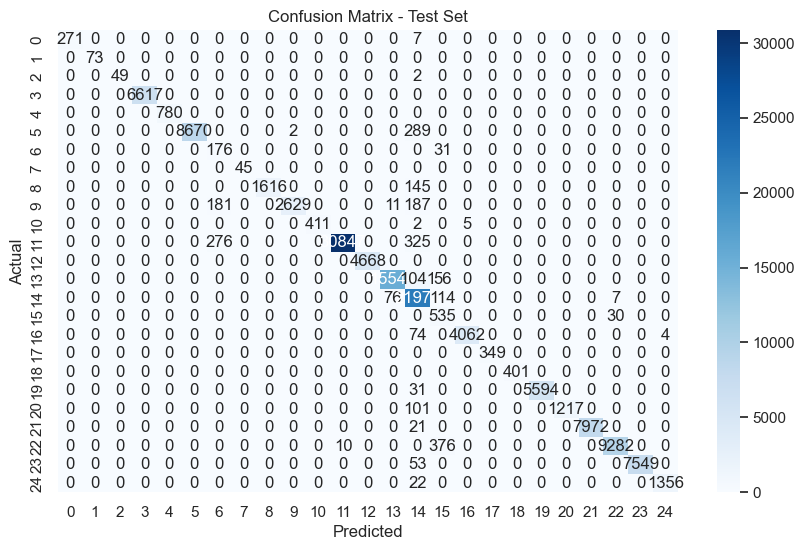

In [28]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The second model improves the Random Forest model by addressing class imbalance using SMOTE (Synthetic Minority Over-sampling Technique), which increases the representation of underrepresented classes. Additionally, class weighting is applied to give more importance to these minority classes. RandomizedSearchCV is used for hyperparameter tuning, allowing the model to efficiently find the best parameters for better performance. These techniques help the model achieve better generalization, avoid bias towards the majority class, and improve classification accuracy on all classes, especially the minority ones.

The second model shows significant improvement over the first. With the application of SMOTE and class weights, the model's recall for underrepresented classes (such as classes 6, 7, and 15) has improved. For example, class 6, which had a recall of 0.85 in the original model, now performs much better. While the precision for class 15 in the test set has improved, the recall remains high at 0.95, highlighting the ability of these techniques to reduce the imbalance and improve model performance on minority classes. The model’s test accuracy increased to 97.4% from the original 95%, with better precision, recall, and F1-scores across all classes, reflecting a more balanced approach to classification. These adjustments allowed the model to generalize better and reduce bias towards the majority class.

## Ensamble model 

In [29]:
# Initialize RandomForest and XGBoost models
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# Create an ensemble model using Voting Classifier
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft', n_jobs=-1)

# Train the ensemble model on resampled data
ensemble_model.fit(X_train_resampled, y_train_resampled)
y_train_pred = ensemble_model.predict(X_train_resampled)
y_test_pred = ensemble_model.predict(X_test)

In [30]:
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print("\nTrain Classification Report:")
print(classification_report(y_train_resampled, y_train_pred))

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9972

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1113
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00       207
           3       1.00      1.00      1.00     26467
           4       1.00      1.00      1.00      3118
           5       1.00      1.00      1.00     35843
           6       1.00      1.00      1.00     12579
           7       1.00      1.00      1.00     12579
           8       1.00      1.00      1.00      7042
           9       1.00      1.00      1.00     12033
          10       1.00      1.00      1.00      1674
          11       1.00      1.00      1.00    125790
          12       1.00      1.00      1.00     18670
          13       1.00      1.00      1.00     66563
          14       1.00      1.00      1.00     88686
          15       0.92      0.96      0.94     12579
          16       1.00     

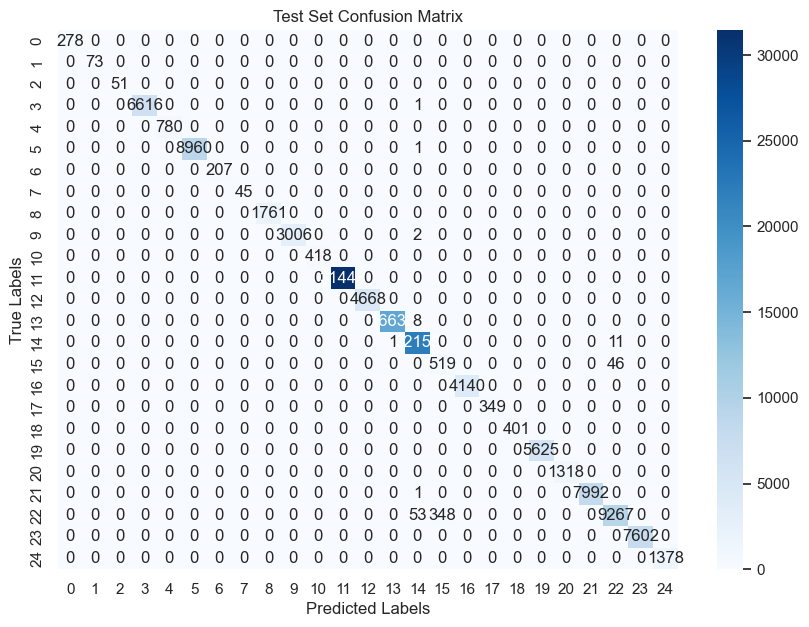

In [32]:
# Plotting the Confusion Matrix for Test Set
plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

I chose an ensemble of RandomForest and XGBoost using soft voting to leverage the strengths of both models. RandomForest is excellent for handling large datasets and avoiding overfitting, while XGBoost is highly efficient and powerful in predictions. Soft voting averages the probabilities, resulting in more accurate outcomes. The ensemble achieved near-perfect performance, with a Train Accuracy of 0.9972 and a Test Accuracy of 0.9965. While the model performed strongly across most classes, there was a slight dip in class 15, but overall, it provides the best balance of accuracy and generalization. I plan to deploy this model as it shows the best results so far. Looking ahead, to further improve the model, I would explore hyperparameter tuning using grid search or Bayesian optimization, experiment with different resampling methods like ADASYN or Borderline-SMOTE, and potentially incorporate neural networks for more complex pattern recognition. Additionally, more feature engineering or expanding the ensemble with additional models could boost performance. However, due to time constraints, I am focusing on deploying the current model, which already offers strong and balanced results.

# Part 2

In [33]:
# Predict crime categories
y_new_pred = ensemble_model.predict(X_test)

# Convert numerical predictions back to category names
predicted_categories = label_encoder.inverse_transform(y_new_pred)

# Function to assign severity based on crime category
def assign_severity(category):
    severity_map = {
        'ROBBERY': 'High',
        'BURGLARY': 'Medium',
        'VEHICLE THEFT': 'Low',
        'LARCENY/THEFT': 'Medium',
        'ARSON': 'High',
        'FRAUD': 'Low',
        'SUSPICIOUS OCC': 'Medium',
        'VANDALISM': 'Low',
        'DRUG/NARCOTIC': 'High',
        'WEAPON LAWS': 'High',
        'KIDNAPPING': 'High',
        'OTHER OFFENSES': 'Low',
        'DISORDERLY CONDUCT': 'Low',
        'WARRANTS': 'Low',  
        'NON-CRIMINAL': 'Low'
    }
    return severity_map.get(category, 'Unknown')  # Default to 'Unknown' if not found

predicted_severity = [assign_severity(category) for category in predicted_categories]

# Create a DataFrame for comparison
predicted_df = pd.DataFrame({
    'Predicted Crime Category': predicted_categories,
    'Predicted Severity': predicted_severity
})
print(predicted_df.head())

  Predicted Crime Category Predicted Severity
0           OTHER OFFENSES                Low
1            LARCENY/THEFT             Medium
2                 WARRANTS                Low
3             NON-CRIMINAL                Low
4           SUSPICIOUS OCC             Medium


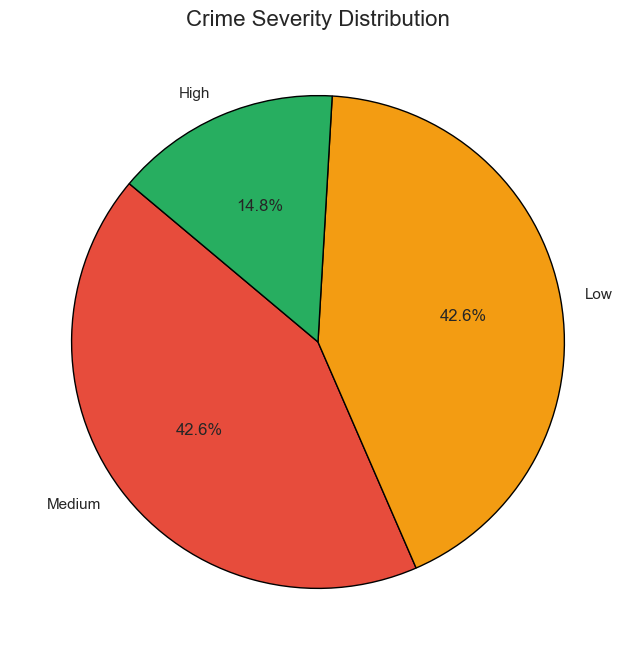

In [34]:
severity_map = {
    'ROBBERY': 'High', 'BURGLARY': 'Medium', 'VEHICLE THEFT': 'Low',
    'LARCENY/THEFT': 'Medium', 'ARSON': 'High', 'FRAUD': 'Low',
    'SUSPICIOUS OCC': 'Medium', 'VANDALISM': 'Low', 'DRUG/NARCOTIC': 'High',
    'WEAPON LAWS': 'High', 'KIDNAPPING': 'High', 'OTHER OFFENSES': 'Low',
    'DISORDERLY CONDUCT': 'Low'
}

df['Severity'] = df['Category'].map(severity_map)
severity_counts = df['Severity'].value_counts()

plt.figure(figsize=(12, 8))  # Ensure the plot has consistent size
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', 
        colors=['#e74c3c', '#f39c12', '#27ae60'], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Crime Severity Distribution", fontsize=16)
plt.show()


I chose to group crime categories into severity levels (e.g., High, Medium, Low) to simplify the comparison of predicted and actual crime severities. This approach provides a more intuitive way to evaluate the model's performance, as it focuses not only on predicting the crime type but also on its impact. By assigning severity levels, I added another layer of analysis that helps assess the model’s ability to predict not just crime types but their relative severity. This severity mapping also aids in identifying trends and patterns, offering valuable insights for decision-making.

## Building the Map

In [35]:
# Create a function to assign a color to each crime category 
def get_color(category):
    color_map = {
        'ROBBERY': 'red',
        'BURGLARY': 'blue',
        'VEHICLE THEFT': 'green',
        'LARCENY/THEFT': 'orange',
        'ARSON': 'purple',
        'FRAUD': 'pink',
        'SUSPICIOUS OCC': 'yellow',
        'VANDALISM': 'brown',
        'DRUG/NARCOTIC': 'darkred',
        'WEAPON LAWS': 'darkgreen',
        'KIDNAPPING': 'darkblue',
        'OTHER OFFENSES': 'lightblue',
        'DISORDERLY CONDUCT': 'gray'
    }
    return color_map.get(category, 'gray')

In [36]:
# Initialize map centered around the dataset's average location (swapped Latitude and Longitude)
map_center = [df['Longitude (X)'].mean(), df['Latitude (Y)'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=12)

#I will limit it to the first 1500 entries for testing purposes
df_limited = df.head(1500)

# Add markers for each crime location to the map (with color based on crime category)
for index, row in df_limited.iterrows():
    crime_category = row['Category']
    latitude = row['Longitude (X)']  
    longitude = row['Latitude (Y)']  
    
    folium.Marker(
        location=[latitude, longitude],  
        popup=f"Category: {crime_category}",  
        icon=folium.Icon(color=get_color(crime_category), icon='info-sign')
    ).add_to(crime_map)

crime_map

/var/folders/vs/yv99xdjd7g71b8gr5582fw5c0000gn/T/ipykernel_1465/3822907796.py:19: UserWarning: color argument of Icon should be one of: {'darkred', 'lightred', 'green', 'pink', 'darkpurple', 'orange', 'red', 'purple', 'darkblue', 'white', 'lightblue', 'lightgray', 'gray', 'lightgreen', 'cadetblue', 'beige', 'blue', 'black', 'darkgreen'}.
  icon=folium.Icon(color=get_color(crime_category), icon='info-sign')


## To deploy the ML, save the models and map.

In [37]:
# Save the ensemble model
joblib.dump(ensemble_model, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [38]:
# Save the label encoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [39]:
# Save the TF-IDF vectorizer to a file
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [40]:
# Save the map to an HTML file (can be opened in a web browser)
crime_map.save("crime_map_with_colors.html")

## Before deploying the model, test it in Jupyter.

In [41]:
# Load the saved label encoder and vectorizer
label_encoder = joblib.load('label_encoder.pkl')
vectorizer = joblib.load('vectorizer.pkl')

new_description = ["Suspicious activity near the park"]# Example of transforming a new crime description
# Convert the description into the same numerical features using the loaded vectorizer
X_new_text = vectorizer.transform(new_description).toarray()

predicted_category_label = 2  # Example predicted category from  model
predicted_category = label_encoder.inverse_transform([predicted_category_label])[0]
print(predicted_category)

BRIBERY


In [44]:
loaded_model = joblib.load('ensemble_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Transform a new crime description and feature (e.g., distance)
new_description = ["car theft"]  # Write whatever
new_distance = 500  # Example distance from center

X_new_text = vectorizer.transform(new_description).toarray()
X_new_final = np.hstack((X_new_text, np.array([[new_distance]])))

predicted_category = loaded_model.predict(X_new_final)
predicted_category_label = predicted_category[0]
predicted_category_name = label_encoder.inverse_transform([predicted_category_label])[0]
print(f"Predicted Category: {predicted_category_name}")

Predicted Category: LARCENY/THEFT
